In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from data.data_handler import SimpleDataset, CondDataset
from models.layers import Reshape
from torch import optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from scipy.stats.mstats import gmean
import torch.distributions as td
from trainer import Trainer
from cond_trainer import CondTrainer

In [2]:
def make_one_hot(labels, C = 5):
    y = torch.eye(C) 
    return y[labels.long()].squeeze(1)

In [3]:
data_dir = "C:/Users/Phili/Documents/exjobb/data/"

In [4]:
# it = pd.read_csv(data_dir + "ItalyPowerDemand_TEST.txt", sep="  ", header=None)
# X = []
# t_list = []
# for i in range(it.shape[0]):
#     it_i = it.iloc[i]
#     X.append(it_i.iloc[1:].values)
#     t_list.append([it_i.iloc[0]])
# X = np.array(X)
# t_list = np.array(t_list) - 1

In [11]:
X = pd.read_csv(data_dir + "stocks.csv").values
y = pd.read_csv(data_dir + "y.csv").values
t_df = pd.read_csv(data_dir + "t.csv")
t_list = t_df.t.values

In [12]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(X, y, t_list, test_size = 0.1)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#train_data = SimpleDataset(torch.from_numpy(X_train), torch.from_numpy(t_train))
#test_data = SimpleDataset(torch.from_numpy(X_test), torch.from_numpy(t_test))
train_data = CondDataset(torch.from_numpy(X_train), torch.from_numpy(y_train), torch.from_numpy(t_train))
test_data = CondDataset(torch.from_numpy(X_test), torch.from_numpy(y_test), torch.from_numpy(t_test))

In [13]:
class Latent(nn.Module):
    def __init__(self, i, o):
        super().__init__()
        self.mu = nn.Linear(i, o)
        self.log_var = nn.Linear(i, o)
        
        self.elu = nn.ELU()
        
    def _rep(self, mu, log_var):
        eps = torch.randn_like(log_var)
        sigma = torch.exp(0.5 * log_var) + 1e-4
        return mu + eps*sigma
    
    def forward(self, x):
        mu = self.mu(x)
        #mu = self.elu(mu)
        log_var = self.log_var(x)
        #log_var = self.elu(log_var)
        z = self._rep(mu, log_var)
        return z, mu, log_var

class Dense(nn.Module):
    def __init__(self, i,o):
        super().__init__()
        self.l = nn.Sequential(
            nn.Linear(i, o),
            #nn.BatchNorm1d(o),
            nn.ELU()
        )
    def forward(self, x):
        return self.l(x)
    
class Normal(nn.Module):
    def __init__(self, i, o):
        super().__init__()
        self.mu = nn.Linear(i, o)
        self.log_var = nn.Linear(i,o)
    
    def forward(self, x):
        mu = self.mu(x)
        log_var = self.log_var(x)
        sigma = torch.exp(0.5 * log_var)
        return td.Normal(mu, sigma)
    
class ST(nn.Module):
    def __init__(self, i, o):
        super().__init__()
        self.df = nn.Sequential(
            nn.Linear(i, o),
            #nn.Softmax()
        )
        self.mu = nn.Linear(i, o)
        self.log_var = nn.Linear(i, o)
    
    def forward(self, x):
        df = self.df(x)
        df = torch.exp(0.5 * df)
        mu = self.mu(x)
        log_var = self.log_var(x)
        sigma = torch.exp(0.5 * log_var)
        return td.StudentT(df, mu, sigma)

In [40]:
class CVAE(nn.Module):
    def __init__(self, T, n_y, n_z):
        super().__init__()
        
        mult = 80
        
        self.enc = nn.Sequential(
            Dense(T + n_y, 128),
            Dense(128, 64),
            Dense(64, 16),
            Latent(16, n_z)
        )
        
        self.prior = nn.Sequential(
            Dense(n_y, 16),
            Latent(16, n_z)
        )
        
        self.dec = nn.Sequential(
            Dense(n_z + n_y, 16),
            Dense(16, 64),
            Dense(64, 128),
            Normal(128, T)
        )
        
        self.mse = nn.MSELoss(reduction="sum")
    
    def _dkl_loss(self, prior_mean, prior_log_var, z_mean, z_log_var):
        z_var = z_log_var.exp()
        prior_var = prior_log_var.exp()
        kld = torch.sum(prior_log_var - z_log_var + ((z_var + (z_mean - prior_mean).pow(2)) / (prior_var*2)) - 0.5)
        return kld
    
    def _rcl_loss(self, dist, x):
        return -dist.log_prob(x).sum()
    
    def encode(self, x,y):
        x = torch.cat([x,y], 1)
        return self.enc(x)

    def decode(self, z, y = None):
        if y is not None:
            z = torch.cat([z,y], 1)
        return self.dec(z)
    
    def forward(self, x, y, beta = 1.0):
        y = make_one_hot(y)
        z, mu, log_var = self.encode(x,y)
        prior, prior_mu, prior_log_var = self.prior(y)
        dkl = self._dkl_loss(prior_mu, prior_log_var, mu, log_var)
        #dkl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        dist = self.decode(z,y)
        rcl = self._rcl_loss(dist, x)
        #rcl = self.mse(dist, x)
        return dist, rcl + dkl*beta, rcl, dkl*beta

In [41]:
n_z = 2
n_y = 5
vae = CVAE(61, n_y, n_z)
t = CondTrainer(vae, train_data, test_data)


In [42]:
losses = t.fit(100, burn_in = 10)

Epoch: 0, Train Loss: 64.01, Test Loss:  59.84
RCL Loss: 64.01, DKL Loss: 0.00
Epoch: 10, Train Loss: 55.27, Test Loss:  56.01
RCL Loss: 55.27, DKL Loss: 0.00
Epoch: 20, Train Loss: 62.22, Test Loss:  62.76
RCL Loss: 59.66, DKL Loss: 2.55
Epoch: 30, Train Loss: 61.87, Test Loss:  62.40
RCL Loss: 59.09, DKL Loss: 2.78
Epoch: 40, Train Loss: 61.47, Test Loss:  62.40
RCL Loss: 58.25, DKL Loss: 3.21
Epoch: 50, Train Loss: 61.28, Test Loss:  62.14
RCL Loss: 57.99, DKL Loss: 3.29
Epoch: 60, Train Loss: 61.18, Test Loss:  61.81
RCL Loss: 57.81, DKL Loss: 3.37
Epoch: 70, Train Loss: 61.12, Test Loss:  61.88
RCL Loss: 57.69, DKL Loss: 3.42
Epoch: 80, Train Loss: 61.06, Test Loss:  62.01
RCL Loss: 57.63, DKL Loss: 3.43
Epoch: 90, Train Loss: 61.02, Test Loss:  61.78
RCL Loss: 57.54, DKL Loss: 3.48


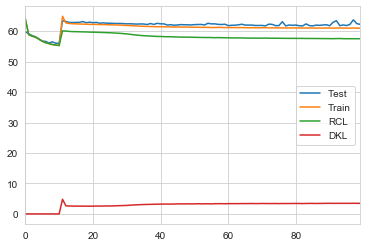

In [43]:
losses.plot()

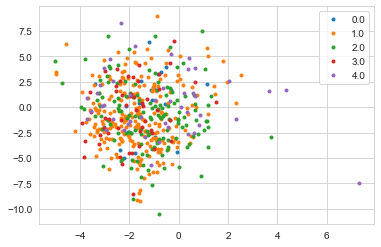

(tensor([-1.4317, -0.7069], grad_fn=<MeanBackward1>),
 tensor([1.8854, 3.2221], grad_fn=<StdBackward1>))

In [44]:
X,y, t = train_data[:500]
y_ = make_one_hot(y)
z, mu, log_var = vae.encode(X, y_)
zz = pd.DataFrame(mu.detach().numpy(), columns = ["x", "y"])
zz["t"] = y.detach().numpy()
fig, ax = plt.subplots()
for name, grp in zz.groupby("t"):
    ax.plot(grp.x, grp.y, marker='o', linestyle='', ms=3, label=name, alpha=1)
ax.legend()
plt.show()
z.mean(dim=0), z.std(dim=0)

In [45]:
def grad(x, dist):
    mu = dist.mean
    sigma = dist.scale
    grad = (x - mu) / sigma.pow(2)
    return grad

def gradm(x, dist):
    return x - dist

def sgd(x, y, vae, N=200, alpha=1, eps = 1):
    z_list = []
    x_list = []
    x_list.append(x.unsqueeze(0))
    z, mu, log_var = vae.encode(x, y)
    z_list.append(mu.unsqueeze(1))
    for i in range(N):
        eps = eps / np.sqrt(i+1)
        x_z = x + np.sqrt(eps) * torch.randn_like(x)
        #print(x_z.shape, "x")
        z, mu, log_var = vae.encode(x_z, y)
        dist = vae.decode(z,y)
        z_list.append(mu.unsqueeze(1))
        g = grad(x_z, dist)
        #print(g.shape, "G")
        x = x - alpha * g / np.sqrt(i+1)
        x_list.append(x.unsqueeze(0))
    return torch.cat(z_list, 1), torch.cat(x_list, 0)

In [46]:
x,y,t = train_data[3:4]
y = make_one_hot(y)
print(x.shape, y.shape)
z_list, x_list = sgd(x,y,vae, 2000, .01, 3)

torch.Size([1, 61]) torch.Size([1, 5])


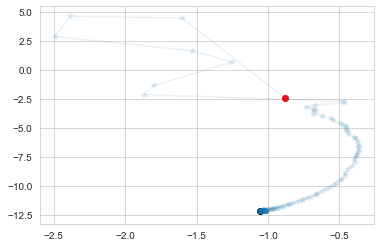

In [47]:
zz = z_list.detach().numpy()
_ = plt.plot(zz[0,:,0], zz[0,:,1],"*-" ,alpha=0.1)
_ = plt.scatter(zz[0,0,0], zz[0,0,1], c="r")
_ = plt.scatter(zz[0,-1,0], zz[0,-1,1], c="black")

In [48]:
print(len(train_data))
with torch.no_grad():
    idx = np.random.choice(np.arange(len(train_data)), 1500, replace=False)
    X, Y,t = train_data[idx]
    Y_ = make_one_hot(Y)
    zz, xx = sgd(X, Y_, vae, 2000, 0.1, 3)
    

23220


In [49]:

zz_df = pd.DataFrame(zz[:,-1].detach().numpy(), columns=["x","y"])
zz_df["hue"] = Y.detach().numpy()[:,0]
zz_first_df = pd.DataFrame(zz[:,0].detach().numpy(), columns = ["x","y"])
zz_first_df["hue"] = Y.detach().numpy()[:,0]

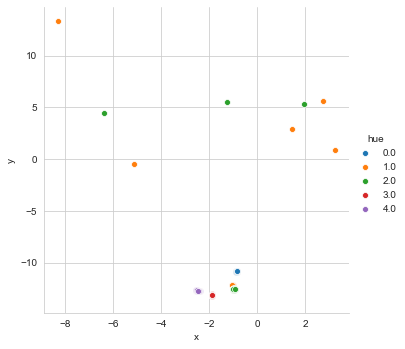

In [50]:
sns.pairplot(x_vars = "x", y_vars = "y", hue="hue", data=zz_df, height=5)

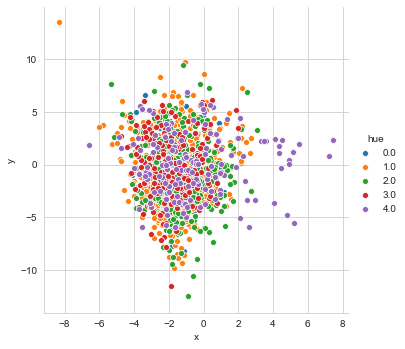

In [51]:
sns.pairplot(x_vars = "x", y_vars = "y", hue="hue", data=zz_first_df, height=5)

In [52]:
zz_df.groupby("hue").mean(), zz_df.groupby("hue").std()

(            x          y
 hue                     
 0.0 -0.871036 -10.849218
 1.0 -1.050478 -12.054015
 2.0 -1.010130 -12.434773
 3.0 -1.894611 -13.155703
 4.0 -2.498634 -12.719661,             x         y
 hue                    
 0.0  0.004461  0.014170
 1.0  0.396665  1.473240
 2.0  0.314643  1.554699
 3.0  0.007123  0.030152
 4.0  0.036648  0.030120)

In [53]:
zz_first_df.groupby("hue").mean(), zz_first_df.groupby("hue").std()

(            x         y
 hue                    
 0.0 -1.493916 -0.235440
 1.0 -1.608514 -0.810448
 2.0 -1.327931 -0.896244
 3.0 -1.780958 -0.423825
 4.0 -0.513388 -0.126259,             x         y
 hue                    
 0.0  1.214081  3.016129
 1.0  1.327416  3.056531
 2.0  1.352761  3.256555
 3.0  1.260905  2.990336
 4.0  2.535109  2.905399)

In [54]:
from sklearn.cluster import KMeans, DBSCAN

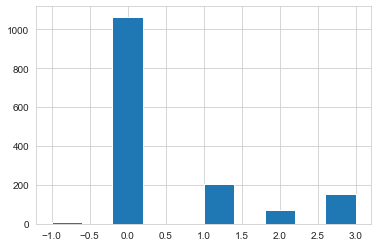

In [62]:
x = xx.detach().numpy()
x_df = pd.DataFrame(scaler.inverse_transform(x[-1]))
kk = DBSCAN().fit_predict(x[-1])
x_df["grp"] = kk
zz_df["grp"] = kk
_ = plt.hist(kk)


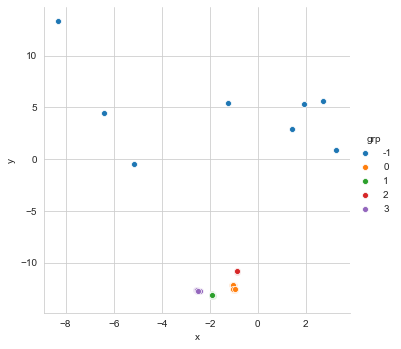

In [63]:
sns.pairplot(x_vars = "x", y_vars = "y", hue="grp", data=zz_df, height=5)

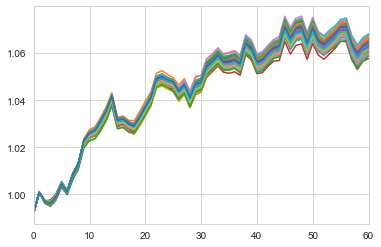

In [64]:
(1.0 + x_df[x_df.grp == 2].drop("grp", axis=1).T).cumprod().plot(legend=False)

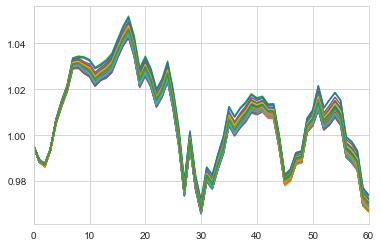

In [65]:
(1.0 + x_df[x_df.grp == 1].drop("grp", axis=1).T).cumprod().plot(legend=False)

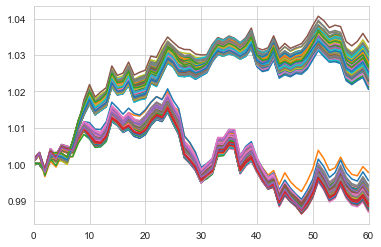

In [66]:
(1.0 + x_df[x_df.grp == 0].drop("grp", axis=1).T).cumprod().plot(legend=False)

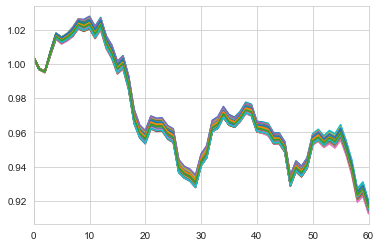

In [67]:
(1.0 + x_df[x_df.grp == 3].drop("grp", axis=1).T).cumprod().plot(legend=False)